In [1]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras as keras

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


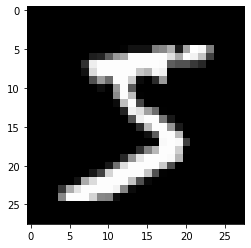

In [6]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

In [7]:
from tensorflow.keras import backend as K
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
BATCH_SIZE = 8
IMG_HEIGHT = 28
IMG_WIDTH = 28

In [9]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT
channels = 1

In [10]:
latent_dim = 50
conv_shape = (3, 3)

In [11]:
input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(input_img)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
x = Flatten()(x)
x = Dense(2 * latent_dim)(x)
x_split = tf.split(x, num_or_size_splits=2, axis=1, name='split')
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(x_split)

In [12]:
encoder = Model(input_img, [x_split[0], x_split[1], z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

#### decoder

In [13]:
input_gen = Input(shape=(latent_dim,))
y = Dense(units=32*7*7, activation='relu')(input_gen)
y = keras.layers.Reshape((7,7,32))(y)
y = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=(1, 1), padding="SAME")(y)
y

<tf.Tensor 'conv2d_transpose_2/Identity:0' shape=(None, 28, 28, 1) dtype=float32>

In [14]:
decoder = Model(input_gen, y)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1568)              79968     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 117,217
Trainable params: 117,217
Non-trainable params: 0
_______________________________________________________

In [15]:
output = decoder(encoder(input_img)[2])
vae = Model(input_img, output)

#### generate loss
some references:
- https://keras.io/examples/variational_autoencoder/
- https://arxiv.org/pdf/1312.6114.pdf

In [16]:
reconstruction_loss = keras.losses.mse(keras.layers.Flatten()(input_img), keras.layers.Flatten()(output))
reconstruction_loss *= 28*28

# custom
# x = keras.layers.Flatten()(input_img)
# hat_x = keras.layers.Flatten()(output)
# reconstruction_loss = tf.math.reduce_sum(tf.math.squared_difference(x, hat_x), axis=1)
## x_split = [z_mean, z_log_var] | 2 * (None, latent_space)

# kl_loss_t = 1 + x_split[1] - tf.math.square(x_split[0]) - tf.math.exp(x_split[1])
# kl_loss_summed = tf.math.reduce_sum(kl_loss_t, axis=1)
# kl_loss = -0.5 * kl_loss_summed

kl_loss = 1 + x_split[1] - K.square(x_split[0]) - K.exp(x_split[1])
kl_loss = K.sum(kl_loss, axis=1)
kl_loss = -0.5 * kl_loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 50), (None,  249316      input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 28, 28, 1)    117217      encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [18]:
epochs = 200

autoencoder_train = vae.fit(
    x=x_train, 
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 13s 209us/sample - loss: 37.7107 - val_loss: 32.6639
Epoch 2/200
60000/60000 [==============================] - 10s 164us/sample - loss: 32.1293 - val_loss: 31.2580
Epoch 3/200
60000/60000 [==============================] - 10s 165us/sample - loss: 30.9792 - val_loss: 30.4649
Epoch 4/200
60000/60000 [==============================] - 10s 165us/sample - loss: 30.3697 - val_loss: 29.9482
Epoch 5/200
60000/60000 [==============================] - 10s 164us/sample - loss: 30.0081 - val_loss: 29.8637
Epoch 6/200
60000/60000 [==============================] - 10s 165us/sample - loss: 29.6970 - val_loss: 29.3470
Epoch 7/200
60000/60000 [==============================] - 10s 165us/sample - loss: 29.4413 - val_loss: 29.1288
Epoch 8/200
60000/60000 [==============================] - 10s 164us/sample - loss: 29.2444 - val_loss: 29.0941
Epoch 9/200
60000/60000 [=============================

Epoch 72/200
60000/60000 [==============================] - 10s 164us/sample - loss: 27.0264 - val_loss: 27.1106
Epoch 73/200
60000/60000 [==============================] - 10s 164us/sample - loss: 27.0392 - val_loss: 27.0343
Epoch 74/200
60000/60000 [==============================] - 10s 165us/sample - loss: 27.0176 - val_loss: 27.0962
Epoch 75/200
60000/60000 [==============================] - 10s 164us/sample - loss: 27.0077 - val_loss: 27.0387
Epoch 76/200
60000/60000 [==============================] - 10s 165us/sample - loss: 26.9975 - val_loss: 27.0752
Epoch 77/200
60000/60000 [==============================] - 10s 164us/sample - loss: 26.9763 - val_loss: 27.0624
Epoch 78/200
60000/60000 [==============================] - 10s 165us/sample - loss: 27.0125 - val_loss: 27.0332
Epoch 79/200
60000/60000 [==============================] - 10s 164us/sample - loss: 26.9791 - val_loss: 27.0533
Epoch 80/200
60000/60000 [==============================] - 10s 164us/sample - loss: 26.9962 - v

In [19]:
vae.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7f80f04b5a50>>

In [31]:
saved = False
if not saved:
    vae.save('./vae_keras_model_{}.hdf5'.format(epochs))
    encoder.save('./vae_encoder_keras_model_{}.hdf5'.format(epochs))
    decoder.save('./vae_decoder_keras_model_{}.hdf5'.format(epochs))    
    saved = True



### load model

In [21]:
loaded_model = tf.keras.models.load_model('./vae_model_100.hdf5')

In [22]:
loaded_model.layers

#### generative process

In [27]:
n_examples = 16

In [28]:
examples = tf.random.normal(shape=[n_examples, latent_dim])

In [29]:
generated = decoder.predict(examples)

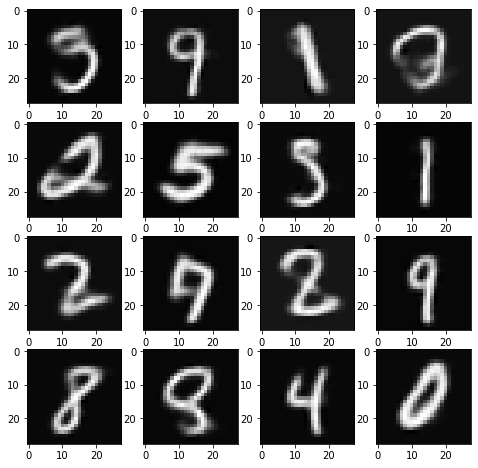

In [30]:
plt.figure(figsize=(8,8))
for i, gen in enumerate(generated):
    plt.subplot(4, 4, i+1)
    plt.imshow(gen[:,:,0], cmap='gray')

In [33]:
z_sample

array([[-4.,  4.]])